In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.optimizers import SGD
from numpy.random import uniform
import keras
from tensorflow.keras import layers

In [2]:
def generate_mixed_shape(shape1, shape2, shape3, shape4):
    shape = []
    shape.extend(shape1[:15].tolist())
    shape.extend(shape2[15:30].tolist())
    shape.extend(shape3[30:45].tolist())
    shape.extend(shape4[45:60].tolist())
    return pd.DataFrame([shape])

In [3]:
def generate_noisy_shape(shape):
    noisyShape = []
    for val in shape:
        noisyShape.append(val + uniform(-0.3, 0.3))
    return pd.DataFrame([noisyShape])

In [4]:
symbol_data = pd.read_csv("data/dataset1_fixed.csv", header=None)
X = symbol_data.iloc[:, :-1]
Y = symbol_data.iloc[:, -1:]
Y = Y.replace("Time", 0)
Y = Y.replace("Wind", 1)
Y = Y.replace("Air", 1)
Y = Y.replace("Fire", 2)
Y = Y.replace("Earth", 3)
Y = Y.replace("Water", 4)
Y = Y.replace("Lightning", 5)

for i in range(500):
    random_symbols = X.sample(n=4)
    X = pd.concat([X, generate_mixed_shape(random_symbols.iloc[0], random_symbols.iloc[1], random_symbols.iloc[2],
                                           random_symbols.iloc[3])])
    Y = pd.concat([Y, pd.DataFrame([6], columns=[60])])

for i in range(500):
    random_symbol = X.sample(n=1)
    X = pd.concat([X, pd.DataFrame(generate_noisy_shape(random_symbol.iloc[0]))])
    Y = pd.concat([Y, pd.DataFrame([6], columns=[60])])

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.20)

y_test = y_test.values.flatten().astype("float64")
y_train = y_train.values.flatten().astype("float64")

In [5]:
x_train_3d = [np.array(x_train[i]).reshape(-1, 3) for i in range(len(x_train))]
x_test_3d = [np.array(x_test[i]).reshape(-1, 3) for i in range(len(x_test))]

x_train_3d = tf.stack(x_train_3d)
x_test_3d = tf.stack(x_test_3d)

In [6]:
print(x_test_3d)

tf.Tensor(
[[[ 0.00000000e+00  8.74827000e-01  6.94161800e-05]
  [ 1.61179700e-01  9.37761600e-01  1.71493300e-04]
  [ 3.20885100e-01  1.00000000e+00  2.21442600e-04]
  ...
  [ 2.00381100e-01  7.25981000e-01  2.56930200e-04]
  [ 8.82094500e-02  7.78049300e-01  2.45900400e-04]
  [ 8.82094500e-02  7.78049300e-01  2.45900400e-04]]

 [[ 6.78036278e-01  1.02921862e+00  2.01215851e-01]
  [ 3.03910064e-01  9.96255645e-01 -1.40335772e-01]
  [ 2.37019064e-01  8.71056389e-01  1.40331280e-01]
  ...
  [ 6.11628440e-02 -2.14167425e-01  2.14593513e-01]
  [ 1.43773589e-01  2.84641616e-01  9.55896704e-02]
  [ 4.76696810e-02 -2.65955142e-01  2.84409258e-01]]

 [[ 3.77066500e-01  1.00000000e+00  1.31689300e-04]
  [ 4.18754800e-01  8.80790000e-01  3.93640100e-04]
  [ 4.48026600e-01  7.62843100e-01  6.03851300e-04]
  ...
  [ 3.17665700e-01  8.63490300e-01  3.19442500e-04]
  [ 4.80179800e-01  1.00000000e+00  4.60060900e-04]
  [ 4.80179800e-01  1.00000000e+00  4.60060900e-04]]

 ...

 [[ 5.14365500e-01  1.0

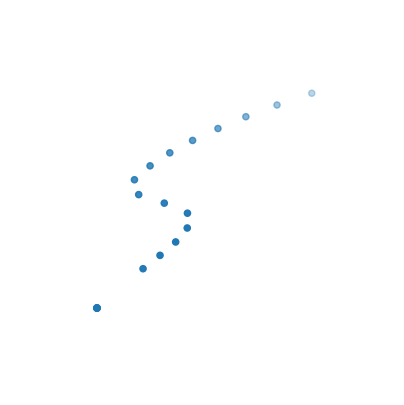

label:  5.0


In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
points = x_train_3d[4]
clas = y_train[4]
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(elev=90, azim=0, roll=90)
plt.show()
print("label: ", clas)

In [8]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [9]:
NUM_POINTS = 20
NUM_CLASSES = 7
BATCH_SIZE = 32

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_3d, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_3d, y_test))

train_dataset = train_dataset.shuffle(len(x_train_3d)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [11]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [12]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [13]:
class OrthogonalRegularizerTest(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {'num_features': float(self.num_features), 'l2reg': float(self.l2reg)}

In [14]:
def tnet(inputs, num_features, subfix):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    # reg = tf.keras.regularizers.OrthogonalRegularizer(factor=0.01, mode="columns")
    # reg = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
    reg = OrthogonalRegularizerTest(num_features)

    x = conv_bn(inputs, 32, subfix + "_1")
    x = conv_bn(x, 64, subfix + "_2")
    x = conv_bn(x, 512, subfix + "_3")
    x = layers.GlobalMaxPooling1D(name="maxpool_" + subfix)(x)
    x = dense_bn(x, 256, subfix + "_4")
    x = dense_bn(x, 256, subfix + "_5")
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
        name="T_" + subfix,
    )(x)
    feat_T = layers.Reshape((num_features, num_features), name="T_reshape_" + subfix)(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1), name="T_dot_" + subfix)([inputs, feat_T])

In [15]:
def conv_bn(x, filters, subfix):
    res = x
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name="conv_" + subfix)(x)
    x = layers.BatchNormalization(momentum=0.0, name="bn_" + subfix)(x)
    if res.type_spec.shape == x.type_spec.shape:
        #print(subfix)
        x =layers.Add()([x,res])
    return layers.Activation("relu", name="relu_" + subfix)(x)


def dense_bn(x, filters, subfix):
    res = x
    x = layers.Dense(filters, name="dense_" + subfix)(x)
    x = layers.BatchNormalization(momentum=0.0, name="bn_" + subfix)(x)
    if res.type_spec.shape == x.type_spec.shape:
        #print(subfix)
        x = layers.Add()([x,res])
    return layers.Activation("relu", name="relu_" + subfix)(x)

In [16]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

embed_dim = 3  # Embedding size for each token
num_heads = 3  # Number of attention heads
ff_dim = 516  # Hidden layer size in feed forward network inside transformer

x = transformer_encoder(inputs, embed_dim, num_heads, ff_dim)
x = tnet(x, 3, "tnet1")
x = conv_bn(x, 32, "1")
x = conv_bn(x, 32,  "2")
x = tnet(x, 32, "tnet2")
x = conv_bn(x, 64, "3")
x = conv_bn(x, 64, "4")
x = conv_bn(x, 512, "5")
x = layers.GlobalMaxPooling1D(name="maxpool1")(x)
x = dense_bn(x, 256, "6")
#x = layers.Dropout(0.3)(x)
x = dense_bn(x, 256, "7")
#x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="outputs")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")

In [17]:
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 3)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 3)       6           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 3)       138         ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                           

                                                                                                  
 bn_2 (BatchNormalization)      (None, 20, 32)       128         ['conv_2[0][0]']                 
                                                                                                  
 add_1 (Add)                    (None, 20, 32)       0           ['bn_2[0][0]',                   
                                                                  'relu_1[0][0]']                 
                                                                                                  
 relu_2 (Activation)            (None, 20, 32)       0           ['add_1[0][0]']                  
                                                                                                  
 conv_tnet2_1 (Conv1D)          (None, 20, 32)       1056        ['relu_2[0][0]']                 
                                                                                                  
 bn_tnet2_

                                                                                                  
 bn_6 (BatchNormalization)      (None, 256)          1024        ['dense_6[0][0]']                
                                                                                                  
 relu_6 (Activation)            (None, 256)          0           ['bn_6[0][0]']                   
                                                                                                  
 dense_7 (Dense)                (None, 256)          65792       ['relu_6[0][0]']                 
                                                                                                  
 bn_7 (BatchNormalization)      (None, 256)          1024        ['dense_7[0][0]']                
                                                                                                  
 add_5 (Add)                    (None, 256)          0           ['bn_7[0][0]',                   
          

In [18]:
filepath = "best_model_test"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=500, validation_data=test_dataset, callbacks=callbacks_list)

Epoch 1/500
58/58 [==============================] - ETA: 0s - loss: 3.0729 - sparse_categorical_accuracy: 0.4981
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.53043, saving model to best_model_test


INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 37s 416ms/step - loss: 3.0729 - sparse_categorical_accuracy: 0.4981 - val_loss: 72685848.0000 - val_sparse_categorical_accuracy: 0.5304
Epoch 2/500
58/58 [==============================] - ETA: 0s - loss: 2.3165 - sparse_categorical_accuracy: 0.6156
Epoch 2: val_sparse_categorical_accuracy improved from 0.53043 to 0.74348, saving model to best_model_test


INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 23s 404ms/step - loss: 2.3165 - sparse_categorical_accuracy: 0.6156 - val_loss: 37.7475 - val_sparse_categorical_accuracy: 0.7435
Epoch 3/500
58/58 [==============================] - ETA: 0s - loss: 2.1128 - sparse_categorical_accuracy: 0.6911
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.74348
58/58 [==============================] - 6s 97ms/step - loss: 2.1128 - sparse_categorical_accuracy: 0.6911 - val_loss: 4.7331 - val_sparse_categorical_accuracy: 0.7304
Epoch 4/500
58/58 [==============================] - ETA: 0s - loss: 1.9359 - sparse_categorical_accuracy: 0.7575
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.74348
58/58 [==============================] - 5s 88ms/step - loss: 1.9359 - sparse_categorical_accuracy: 0.7575 - val_loss: 2394178.5000 - val_sparse_categorical_accuracy: 0.6957
Epoch 5/500
58/58 [==============================] - ETA: 0s - loss: 1.9095 - sparse_categorical_accuracy: 0.7423
Epoch

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 22s 377ms/step - loss: 1.9095 - sparse_categorical_accuracy: 0.7423 - val_loss: 15.2276 - val_sparse_categorical_accuracy: 0.7891
Epoch 6/500
58/58 [==============================] - ETA: 0s - loss: 1.8071 - sparse_categorical_accuracy: 0.7879
Epoch 6: val_sparse_categorical_accuracy improved from 0.78913 to 0.80652, saving model to best_model_test


INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 23s 404ms/step - loss: 1.8071 - sparse_categorical_accuracy: 0.7879 - val_loss: 1.7603 - val_sparse_categorical_accuracy: 0.8065
Epoch 7/500
58/58 [==============================] - ETA: 0s - loss: 1.7661 - sparse_categorical_accuracy: 0.7955
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.80652
58/58 [==============================] - 6s 97ms/step - loss: 1.7661 - sparse_categorical_accuracy: 0.7955 - val_loss: 11801.8340 - val_sparse_categorical_accuracy: 0.7826
Epoch 8/500
58/58 [==============================] - ETA: 0s - loss: 1.6929 - sparse_categorical_accuracy: 0.8200
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.80652
58/58 [==============================] - 5s 90ms/step - loss: 1.6929 - sparse_categorical_accuracy: 0.8200 - val_loss: 36393.7227 - val_sparse_categorical_accuracy: 0.7891
Epoch 9/500
58/58 [==============================] - ETA: 0s - loss: 1.6891 - sparse_categorical_accuracy: 0.8173
Epoc

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 23s 407ms/step - loss: 1.6590 - sparse_categorical_accuracy: 0.8325 - val_loss: 1.5774 - val_sparse_categorical_accuracy: 0.8696
Epoch 13/500
58/58 [==============================] - ETA: 0s - loss: 1.5502 - sparse_categorical_accuracy: 0.8700
Epoch 13: val_sparse_categorical_accuracy did not improve from 0.86957
58/58 [==============================] - 6s 107ms/step - loss: 1.5502 - sparse_categorical_accuracy: 0.8700 - val_loss: 10662.7432 - val_sparse_categorical_accuracy: 0.8304
Epoch 14/500
58/58 [==============================] - ETA: 0s - loss: 1.6161 - sparse_categorical_accuracy: 0.8477
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.86957
58/58 [==============================] - 5s 94ms/step - loss: 1.6161 - sparse_categorical_accuracy: 0.8477 - val_loss: 1.9182 - val_sparse_categorical_accuracy: 0.7543
Epoch 15/500
58/58 [==============================] - ETA: 0s - loss: 1.5529 - sparse_categorical_accuracy: 0.8570
Ep

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 23s 409ms/step - loss: 1.4600 - sparse_categorical_accuracy: 0.8880 - val_loss: 2.6390 - val_sparse_categorical_accuracy: 0.8783
Epoch 24/500
58/58 [==============================] - ETA: 0s - loss: 1.4549 - sparse_categorical_accuracy: 0.9016
Epoch 24: val_sparse_categorical_accuracy did not improve from 0.87826
58/58 [==============================] - 6s 104ms/step - loss: 1.4549 - sparse_categorical_accuracy: 0.9016 - val_loss: 1.6425 - val_sparse_categorical_accuracy: 0.8739
Epoch 25/500
58/58 [==============================] - ETA: 0s - loss: 1.3814 - sparse_categorical_accuracy: 0.9152
Epoch 25: val_sparse_categorical_accuracy did not improve from 0.87826
58/58 [==============================] - 5s 93ms/step - loss: 1.3814 - sparse_categorical_accuracy: 0.9152 - val_loss: 28.1091 - val_sparse_categorical_accuracy: 0.8239
Epoch 26/500
58/58 [==============================] - ETA: 0s - loss: 1.3999 - sparse_categorical_accuracy: 0.9054
Epoch

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 23s 399ms/step - loss: 1.3431 - sparse_categorical_accuracy: 0.9195 - val_loss: 9.6549 - val_sparse_categorical_accuracy: 0.8978
Epoch 29/500
58/58 [==============================] - ETA: 0s - loss: 1.3579 - sparse_categorical_accuracy: 0.9163
Epoch 29: val_sparse_categorical_accuracy did not improve from 0.89783
58/58 [==============================] - 6s 102ms/step - loss: 1.3579 - sparse_categorical_accuracy: 0.9163 - val_loss: 4.4139 - val_sparse_categorical_accuracy: 0.8109
Epoch 30/500
58/58 [==============================] - ETA: 0s - loss: 1.4665 - sparse_categorical_accuracy: 0.8918
Epoch 30: val_sparse_categorical_accuracy did not improve from 0.89783
58/58 [==============================] - 5s 92ms/step - loss: 1.4665 - sparse_categorical_accuracy: 0.8918 - val_loss: 1.6621 - val_sparse_categorical_accuracy: 0.8761
Epoch 31/500
58/58 [==============================] - ETA: 0s - loss: 1.3523 - sparse_categorical_accuracy: 0.9250
Epoch 

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 22s 385ms/step - loss: 1.2762 - sparse_categorical_accuracy: 0.9429 - val_loss: 3.4629 - val_sparse_categorical_accuracy: 0.9065
Epoch 43/500
58/58 [==============================] - ETA: 0s - loss: 1.2526 - sparse_categorical_accuracy: 0.9505
Epoch 43: val_sparse_categorical_accuracy did not improve from 0.90652
58/58 [==============================] - 6s 101ms/step - loss: 1.2526 - sparse_categorical_accuracy: 0.9505 - val_loss: 1.6731 - val_sparse_categorical_accuracy: 0.8652
Epoch 44/500
58/58 [==============================] - ETA: 0s - loss: 1.3037 - sparse_categorical_accuracy: 0.9342
Epoch 44: val_sparse_categorical_accuracy did not improve from 0.90652
58/58 [==============================] - 5s 92ms/step - loss: 1.3037 - sparse_categorical_accuracy: 0.9342 - val_loss: 1.6495 - val_sparse_categorical_accuracy: 0.8435
Epoch 45/500
58/58 [==============================] - ETA: 0s - loss: 1.3034 - sparse_categorical_accuracy: 0.9320
Epoch 

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 22s 389ms/step - loss: 1.2509 - sparse_categorical_accuracy: 0.9500 - val_loss: 33.8292 - val_sparse_categorical_accuracy: 0.9087
Epoch 47/500
58/58 [==============================] - ETA: 0s - loss: 1.3726 - sparse_categorical_accuracy: 0.9255
Epoch 47: val_sparse_categorical_accuracy did not improve from 0.90870
58/58 [==============================] - 6s 102ms/step - loss: 1.3726 - sparse_categorical_accuracy: 0.9255 - val_loss: 1.6190 - val_sparse_categorical_accuracy: 0.8587
Epoch 48/500
58/58 [==============================] - ETA: 0s - loss: 1.2451 - sparse_categorical_accuracy: 0.9549
Epoch 48: val_sparse_categorical_accuracy did not improve from 0.90870
58/58 [==============================] - 5s 90ms/step - loss: 1.2451 - sparse_categorical_accuracy: 0.9549 - val_loss: 1.6261 - val_sparse_categorical_accuracy: 0.8717
Epoch 49/500
58/58 [==============================] - ETA: 0s - loss: 1.2244 - sparse_categorical_accuracy: 0.9549
Epoch

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 25s 433ms/step - loss: 1.2244 - sparse_categorical_accuracy: 0.9549 - val_loss: 1.6988 - val_sparse_categorical_accuracy: 0.9130
Epoch 50/500
58/58 [==============================] - ETA: 0s - loss: 1.2505 - sparse_categorical_accuracy: 0.9456
Epoch 50: val_sparse_categorical_accuracy improved from 0.91304 to 0.91739, saving model to best_model_test


INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 25s 441ms/step - loss: 1.2505 - sparse_categorical_accuracy: 0.9456 - val_loss: 1.6105 - val_sparse_categorical_accuracy: 0.9174
Epoch 51/500
58/58 [==============================] - ETA: 0s - loss: 1.2438 - sparse_categorical_accuracy: 0.9532
Epoch 51: val_sparse_categorical_accuracy did not improve from 0.91739
58/58 [==============================] - 6s 107ms/step - loss: 1.2438 - sparse_categorical_accuracy: 0.9532 - val_loss: 2.3030 - val_sparse_categorical_accuracy: 0.8761
Epoch 52/500
58/58 [==============================] - ETA: 0s - loss: 1.2163 - sparse_categorical_accuracy: 0.9538
Epoch 52: val_sparse_categorical_accuracy did not improve from 0.91739
58/58 [==============================] - 6s 96ms/step - loss: 1.2163 - sparse_categorical_accuracy: 0.9538 - val_loss: 22.9664 - val_sparse_categorical_accuracy: 0.9043
Epoch 53/500
58/58 [==============================] - ETA: 0s - loss: 1.2053 - sparse_categorical_accuracy: 0.9581
Epoch

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 23s 399ms/step - loss: 1.2218 - sparse_categorical_accuracy: 0.9603 - val_loss: 1.6104 - val_sparse_categorical_accuracy: 0.9217
Epoch 59/500
58/58 [==============================] - ETA: 0s - loss: 1.2147 - sparse_categorical_accuracy: 0.9598
Epoch 59: val_sparse_categorical_accuracy did not improve from 0.92174
58/58 [==============================] - 6s 103ms/step - loss: 1.2147 - sparse_categorical_accuracy: 0.9598 - val_loss: 1.7570 - val_sparse_categorical_accuracy: 0.8348
Epoch 60/500
58/58 [==============================] - ETA: 0s - loss: 1.1786 - sparse_categorical_accuracy: 0.9706
Epoch 60: val_sparse_categorical_accuracy did not improve from 0.92174
58/58 [==============================] - 6s 96ms/step - loss: 1.1786 - sparse_categorical_accuracy: 0.9706 - val_loss: 53.7974 - val_sparse_categorical_accuracy: 0.8500
Epoch 61/500
58/58 [==============================] - ETA: 0s - loss: 1.1693 - sparse_categorical_accuracy: 0.9679
Epoch

Epoch 82/500
58/58 [==============================] - ETA: 0s - loss: 1.1538 - sparse_categorical_accuracy: 0.9744
Epoch 82: val_sparse_categorical_accuracy did not improve from 0.92174
58/58 [==============================] - 6s 100ms/step - loss: 1.1538 - sparse_categorical_accuracy: 0.9744 - val_loss: 1.6405 - val_sparse_categorical_accuracy: 0.8891
Epoch 83/500
58/58 [==============================] - ETA: 0s - loss: 1.2137 - sparse_categorical_accuracy: 0.9619
Epoch 83: val_sparse_categorical_accuracy did not improve from 0.92174
58/58 [==============================] - 5s 93ms/step - loss: 1.2137 - sparse_categorical_accuracy: 0.9619 - val_loss: 3.6417 - val_sparse_categorical_accuracy: 0.8761
Epoch 84/500
58/58 [==============================] - ETA: 0s - loss: 1.1747 - sparse_categorical_accuracy: 0.9723
Epoch 84: val_sparse_categorical_accuracy did not improve from 0.92174
58/58 [==============================] - 6s 96ms/step - loss: 1.1747 - sparse_categorical_accuracy: 0.972

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 24s 419ms/step - loss: 1.1283 - sparse_categorical_accuracy: 0.9821 - val_loss: 1.3267 - val_sparse_categorical_accuracy: 0.9326
Epoch 92/500
58/58 [==============================] - ETA: 0s - loss: 1.1380 - sparse_categorical_accuracy: 0.9788
Epoch 92: val_sparse_categorical_accuracy did not improve from 0.93261
58/58 [==============================] - 6s 101ms/step - loss: 1.1380 - sparse_categorical_accuracy: 0.9788 - val_loss: 3.7436 - val_sparse_categorical_accuracy: 0.8913
Epoch 93/500
58/58 [==============================] - ETA: 0s - loss: 1.1710 - sparse_categorical_accuracy: 0.9739
Epoch 93: val_sparse_categorical_accuracy did not improve from 0.93261
58/58 [==============================] - 5s 94ms/step - loss: 1.1710 - sparse_categorical_accuracy: 0.9739 - val_loss: 1.9079 - val_sparse_categorical_accuracy: 0.9043
Epoch 94/500
58/58 [==============================] - ETA: 0s - loss: 1.1496 - sparse_categorical_accuracy: 0.9761
Epoch 

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 24s 427ms/step - loss: 1.1749 - sparse_categorical_accuracy: 0.9712 - val_loss: 1.4288 - val_sparse_categorical_accuracy: 0.9370
Epoch 111/500
58/58 [==============================] - ETA: 0s - loss: 1.1396 - sparse_categorical_accuracy: 0.9804
Epoch 111: val_sparse_categorical_accuracy did not improve from 0.93696
58/58 [==============================] - 6s 104ms/step - loss: 1.1396 - sparse_categorical_accuracy: 0.9804 - val_loss: 1.6276 - val_sparse_categorical_accuracy: 0.9130
Epoch 112/500
58/58 [==============================] - ETA: 0s - loss: 1.1097 - sparse_categorical_accuracy: 0.9880
Epoch 112: val_sparse_categorical_accuracy did not improve from 0.93696
58/58 [==============================] - 5s 91ms/step - loss: 1.1097 - sparse_categorical_accuracy: 0.9880 - val_loss: 1.8587 - val_sparse_categorical_accuracy: 0.8848
Epoch 113/500
58/58 [==============================] - ETA: 0s - loss: 1.1337 - sparse_categorical_accuracy: 0.9831
E

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 24s 419ms/step - loss: 1.1223 - sparse_categorical_accuracy: 0.9842 - val_loss: 1.3400 - val_sparse_categorical_accuracy: 0.9543
Epoch 130/500
58/58 [==============================] - ETA: 0s - loss: 1.1193 - sparse_categorical_accuracy: 0.9869
Epoch 130: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 6s 97ms/step - loss: 1.1193 - sparse_categorical_accuracy: 0.9869 - val_loss: 1.3750 - val_sparse_categorical_accuracy: 0.9326
Epoch 131/500
58/58 [==============================] - ETA: 0s - loss: 1.1081 - sparse_categorical_accuracy: 0.9880
Epoch 131: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 84ms/step - loss: 1.1081 - sparse_categorical_accuracy: 0.9880 - val_loss: 2.1919 - val_sparse_categorical_accuracy: 0.9109
Epoch 132/500
58/58 [==============================] - ETA: 0s - loss: 1.1067 - sparse_categorical_accuracy: 0.9848
Ep

58/58 [==============================] - 5s 93ms/step - loss: 1.1237 - sparse_categorical_accuracy: 0.9853 - val_loss: 2.0565 - val_sparse_categorical_accuracy: 0.9217
Epoch 153/500
58/58 [==============================] - ETA: 0s - loss: 1.1056 - sparse_categorical_accuracy: 0.9897
Epoch 153: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 88ms/step - loss: 1.1056 - sparse_categorical_accuracy: 0.9897 - val_loss: 1.5340 - val_sparse_categorical_accuracy: 0.9022
Epoch 154/500
58/58 [==============================] - ETA: 0s - loss: 1.1362 - sparse_categorical_accuracy: 0.9826
Epoch 154: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 6s 96ms/step - loss: 1.1362 - sparse_categorical_accuracy: 0.9826 - val_loss: 106.4322 - val_sparse_categorical_accuracy: 0.9152
Epoch 155/500
58/58 [==============================] - ETA: 0s - loss: 1.0991 - sparse_categorical_accuracy: 0.9897
Ep

58/58 [==============================] - 5s 90ms/step - loss: 1.1915 - sparse_categorical_accuracy: 0.9772 - val_loss: 34.1127 - val_sparse_categorical_accuracy: 0.8435
Epoch 176/500
58/58 [==============================] - ETA: 0s - loss: 1.1729 - sparse_categorical_accuracy: 0.9793
Epoch 176: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 89ms/step - loss: 1.1729 - sparse_categorical_accuracy: 0.9793 - val_loss: 2.0164 - val_sparse_categorical_accuracy: 0.8826
Epoch 177/500
58/58 [==============================] - ETA: 0s - loss: 1.1760 - sparse_categorical_accuracy: 0.9717
Epoch 177: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 87ms/step - loss: 1.1760 - sparse_categorical_accuracy: 0.9717 - val_loss: 1.5178 - val_sparse_categorical_accuracy: 0.9261
Epoch 178/500
58/58 [==============================] - ETA: 0s - loss: 1.1452 - sparse_categorical_accuracy: 0.9821
Epo

Epoch 199/500
58/58 [==============================] - ETA: 0s - loss: 1.1018 - sparse_categorical_accuracy: 0.9908
Epoch 199: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 84ms/step - loss: 1.1018 - sparse_categorical_accuracy: 0.9908 - val_loss: 1.6107 - val_sparse_categorical_accuracy: 0.9000
Epoch 200/500
58/58 [==============================] - ETA: 0s - loss: 1.0800 - sparse_categorical_accuracy: 0.9951
Epoch 200: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 85ms/step - loss: 1.0800 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.6662 - val_sparse_categorical_accuracy: 0.9087
Epoch 201/500
58/58 [==============================] - ETA: 0s - loss: 1.0734 - sparse_categorical_accuracy: 0.9962
Epoch 201: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 84ms/step - loss: 1.0734 - sparse_categorical_accuracy: 

58/58 [==============================] - ETA: 0s - loss: 1.0853 - sparse_categorical_accuracy: 0.9956
Epoch 222: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 90ms/step - loss: 1.0853 - sparse_categorical_accuracy: 0.9956 - val_loss: 1.6284 - val_sparse_categorical_accuracy: 0.9326
Epoch 223/500
58/58 [==============================] - ETA: 0s - loss: 1.0927 - sparse_categorical_accuracy: 0.9946
Epoch 223: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 92ms/step - loss: 1.0927 - sparse_categorical_accuracy: 0.9946 - val_loss: 1.5910 - val_sparse_categorical_accuracy: 0.9217
Epoch 224/500
58/58 [==============================] - ETA: 0s - loss: 1.0951 - sparse_categorical_accuracy: 0.9897
Epoch 224: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 5s 87ms/step - loss: 1.0951 - sparse_categorical_accuracy: 0.9897 - val_l

58/58 [==============================] - ETA: 0s - loss: 1.0879 - sparse_categorical_accuracy: 0.9946
Epoch 245: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 6s 101ms/step - loss: 1.0879 - sparse_categorical_accuracy: 0.9946 - val_loss: 1.3037 - val_sparse_categorical_accuracy: 0.9478
Epoch 246/500
58/58 [==============================] - ETA: 0s - loss: 1.0819 - sparse_categorical_accuracy: 0.9929
Epoch 246: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 6s 98ms/step - loss: 1.0819 - sparse_categorical_accuracy: 0.9929 - val_loss: 1.4096 - val_sparse_categorical_accuracy: 0.9457
Epoch 247/500
58/58 [==============================] - ETA: 0s - loss: 1.0957 - sparse_categorical_accuracy: 0.9940
Epoch 247: val_sparse_categorical_accuracy did not improve from 0.95435
58/58 [==============================] - 6s 97ms/step - loss: 1.0957 - sparse_categorical_accuracy: 0.9940 - val_

INFO:tensorflow:Assets written to: best_model_test\assets


INFO:tensorflow:Assets written to: best_model_test\assets


58/58 [==============================] - 24s 427ms/step - loss: 1.0934 - sparse_categorical_accuracy: 0.9935 - val_loss: 1.2605 - val_sparse_categorical_accuracy: 0.9674
Epoch 261/500
58/58 [==============================] - ETA: 0s - loss: 1.0820 - sparse_categorical_accuracy: 0.9951
Epoch 261: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 104ms/step - loss: 1.0820 - sparse_categorical_accuracy: 0.9951 - val_loss: 20.3537 - val_sparse_categorical_accuracy: 0.8978
Epoch 262/500
58/58 [==============================] - ETA: 0s - loss: 1.1313 - sparse_categorical_accuracy: 0.9821
Epoch 262: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 100ms/step - loss: 1.1313 - sparse_categorical_accuracy: 0.9821 - val_loss: 1.9230 - val_sparse_categorical_accuracy: 0.9326
Epoch 263/500
58/58 [==============================] - ETA: 0s - loss: 1.1052 - sparse_categorical_accuracy: 0.9902

58/58 [==============================] - 5s 94ms/step - loss: 1.1044 - sparse_categorical_accuracy: 0.9886 - val_loss: 1.3709 - val_sparse_categorical_accuracy: 0.9348
Epoch 284/500
58/58 [==============================] - ETA: 0s - loss: 1.0933 - sparse_categorical_accuracy: 0.9929
Epoch 284: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 94ms/step - loss: 1.0933 - sparse_categorical_accuracy: 0.9929 - val_loss: 1.3277 - val_sparse_categorical_accuracy: 0.9565
Epoch 285/500
58/58 [==============================] - ETA: 0s - loss: 1.0838 - sparse_categorical_accuracy: 0.9929
Epoch 285: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 91ms/step - loss: 1.0838 - sparse_categorical_accuracy: 0.9929 - val_loss: 1.3314 - val_sparse_categorical_accuracy: 0.9457
Epoch 286/500
58/58 [==============================] - ETA: 0s - loss: 1.0977 - sparse_categorical_accuracy: 0.9902
Epoc

58/58 [==============================] - 6s 102ms/step - loss: 1.0888 - sparse_categorical_accuracy: 0.9918 - val_loss: 1.3224 - val_sparse_categorical_accuracy: 0.9587
Epoch 307/500
58/58 [==============================] - ETA: 0s - loss: 1.0704 - sparse_categorical_accuracy: 0.9967
Epoch 307: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 95ms/step - loss: 1.0704 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.6487 - val_sparse_categorical_accuracy: 0.9174
Epoch 308/500
58/58 [==============================] - ETA: 0s - loss: 1.0925 - sparse_categorical_accuracy: 0.9967
Epoch 308: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 100ms/step - loss: 1.0925 - sparse_categorical_accuracy: 0.9967 - val_loss: 69459.9219 - val_sparse_categorical_accuracy: 0.7435
Epoch 309/500
58/58 [==============================] - ETA: 0s - loss: 1.2471 - sparse_categorical_accuracy: 0.957

58/58 [==============================] - 6s 104ms/step - loss: 1.0727 - sparse_categorical_accuracy: 0.9973 - val_loss: 1.3828 - val_sparse_categorical_accuracy: 0.9478
Epoch 330/500
58/58 [==============================] - ETA: 0s - loss: 1.0713 - sparse_categorical_accuracy: 0.9962
Epoch 330: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 101ms/step - loss: 1.0713 - sparse_categorical_accuracy: 0.9962 - val_loss: 109.4384 - val_sparse_categorical_accuracy: 0.9130
Epoch 331/500
58/58 [==============================] - ETA: 0s - loss: 1.0635 - sparse_categorical_accuracy: 0.9989
Epoch 331: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 102ms/step - loss: 1.0635 - sparse_categorical_accuracy: 0.9989 - val_loss: 1.3011 - val_sparse_categorical_accuracy: 0.9413
Epoch 332/500
58/58 [==============================] - ETA: 0s - loss: 1.0680 - sparse_categorical_accuracy: 0.9978

58/58 [==============================] - 6s 108ms/step - loss: 1.0858 - sparse_categorical_accuracy: 0.9946 - val_loss: 1.4330 - val_sparse_categorical_accuracy: 0.9478
Epoch 353/500
58/58 [==============================] - ETA: 0s - loss: 1.0811 - sparse_categorical_accuracy: 0.9951
Epoch 353: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 100ms/step - loss: 1.0811 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.6618 - val_sparse_categorical_accuracy: 0.9109
Epoch 354/500
58/58 [==============================] - ETA: 0s - loss: 1.0788 - sparse_categorical_accuracy: 0.9956
Epoch 354: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 104ms/step - loss: 1.0788 - sparse_categorical_accuracy: 0.9956 - val_loss: 1.3012 - val_sparse_categorical_accuracy: 0.9435
Epoch 355/500
58/58 [==============================] - ETA: 0s - loss: 1.0670 - sparse_categorical_accuracy: 0.9989
E

58/58 [==============================] - 6s 100ms/step - loss: 1.0772 - sparse_categorical_accuracy: 0.9946 - val_loss: 2.2166 - val_sparse_categorical_accuracy: 0.9196
Epoch 376/500
58/58 [==============================] - ETA: 0s - loss: 1.0817 - sparse_categorical_accuracy: 0.9924
Epoch 376: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 99ms/step - loss: 1.0817 - sparse_categorical_accuracy: 0.9924 - val_loss: 1.6206 - val_sparse_categorical_accuracy: 0.9130
Epoch 377/500
58/58 [==============================] - ETA: 0s - loss: 1.0772 - sparse_categorical_accuracy: 0.9951
Epoch 377: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 6s 109ms/step - loss: 1.0772 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.4442 - val_sparse_categorical_accuracy: 0.9478
Epoch 378/500
58/58 [==============================] - ETA: 0s - loss: 1.0736 - sparse_categorical_accuracy: 0.9962
Ep

58/58 [==============================] - 5s 89ms/step - loss: 1.0741 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.5691 - val_sparse_categorical_accuracy: 0.9283
Epoch 399/500
58/58 [==============================] - ETA: 0s - loss: 1.0833 - sparse_categorical_accuracy: 0.9946
Epoch 399: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 91ms/step - loss: 1.0833 - sparse_categorical_accuracy: 0.9946 - val_loss: 19183.3770 - val_sparse_categorical_accuracy: 0.8109
Epoch 400/500
58/58 [==============================] - ETA: 0s - loss: 1.1268 - sparse_categorical_accuracy: 0.9837
Epoch 400: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 92ms/step - loss: 1.1268 - sparse_categorical_accuracy: 0.9837 - val_loss: 25566.6797 - val_sparse_categorical_accuracy: 0.7630
Epoch 401/500
58/58 [==============================] - ETA: 0s - loss: 1.1270 - sparse_categorical_accuracy: 0.9

58/58 [==============================] - 5s 90ms/step - loss: 1.0677 - sparse_categorical_accuracy: 0.9967 - val_loss: 2.7380 - val_sparse_categorical_accuracy: 0.8739
Epoch 422/500
58/58 [==============================] - ETA: 0s - loss: 1.0820 - sparse_categorical_accuracy: 0.9924
Epoch 422: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 88ms/step - loss: 1.0820 - sparse_categorical_accuracy: 0.9924 - val_loss: 1.7867 - val_sparse_categorical_accuracy: 0.9065
Epoch 423/500
58/58 [==============================] - ETA: 0s - loss: 1.0963 - sparse_categorical_accuracy: 0.9913
Epoch 423: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 89ms/step - loss: 1.0963 - sparse_categorical_accuracy: 0.9913 - val_loss: 2.0410 - val_sparse_categorical_accuracy: 0.8609
Epoch 424/500
58/58 [==============================] - ETA: 0s - loss: 1.0904 - sparse_categorical_accuracy: 0.9940
Epoc

58/58 [==============================] - 5s 89ms/step - loss: 1.1545 - sparse_categorical_accuracy: 0.9750 - val_loss: 2.0428 - val_sparse_categorical_accuracy: 0.8957
Epoch 445/500
58/58 [==============================] - ETA: 0s - loss: 1.1314 - sparse_categorical_accuracy: 0.9777
Epoch 445: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 91ms/step - loss: 1.1314 - sparse_categorical_accuracy: 0.9777 - val_loss: 1.6659 - val_sparse_categorical_accuracy: 0.8761
Epoch 446/500
58/58 [==============================] - ETA: 0s - loss: 1.1282 - sparse_categorical_accuracy: 0.9782
Epoch 446: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 93ms/step - loss: 1.1282 - sparse_categorical_accuracy: 0.9782 - val_loss: 1.6923 - val_sparse_categorical_accuracy: 0.8478
Epoch 447/500
58/58 [==============================] - ETA: 0s - loss: 1.1365 - sparse_categorical_accuracy: 0.9761
Epoc

Epoch 468/500
58/58 [==============================] - ETA: 0s - loss: 1.0839 - sparse_categorical_accuracy: 0.9946
Epoch 468: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 93ms/step - loss: 1.0839 - sparse_categorical_accuracy: 0.9946 - val_loss: 1.5724 - val_sparse_categorical_accuracy: 0.9283
Epoch 469/500
58/58 [==============================] - ETA: 0s - loss: 1.0921 - sparse_categorical_accuracy: 0.9891
Epoch 469: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 92ms/step - loss: 1.0921 - sparse_categorical_accuracy: 0.9891 - val_loss: 4.1887 - val_sparse_categorical_accuracy: 0.8913
Epoch 470/500
58/58 [==============================] - ETA: 0s - loss: 1.0865 - sparse_categorical_accuracy: 0.9902
Epoch 470: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 90ms/step - loss: 1.0865 - sparse_categorical_accuracy: 

58/58 [==============================] - ETA: 0s - loss: 1.0762 - sparse_categorical_accuracy: 0.9967
Epoch 491: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 88ms/step - loss: 1.0762 - sparse_categorical_accuracy: 0.9967 - val_loss: 2.3546 - val_sparse_categorical_accuracy: 0.9065
Epoch 492/500
58/58 [==============================] - ETA: 0s - loss: 1.0738 - sparse_categorical_accuracy: 0.9956
Epoch 492: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 90ms/step - loss: 1.0738 - sparse_categorical_accuracy: 0.9956 - val_loss: 1.5503 - val_sparse_categorical_accuracy: 0.9326
Epoch 493/500
58/58 [==============================] - ETA: 0s - loss: 1.0681 - sparse_categorical_accuracy: 0.9995
Epoch 493: val_sparse_categorical_accuracy did not improve from 0.96739
58/58 [==============================] - 5s 89ms/step - loss: 1.0681 - sparse_categorical_accuracy: 0.9995 - val_l

In [31]:
model = tf.keras.models.load_model('best_model_test', custom_objects={"OrthogonalRegularizerTest": OrthogonalRegularizerTest},
)
model.summary()

RuntimeError: Unable to restore object of class 'Dense' likely due to name conflict with built-in Keras class '<class 'keras.layers.core.dense.Dense'>'. To override the built-in Keras definition of the object, decorate your class with `@keras.utils.register_keras_serializable` and include that file in your program, or pass your class in a `keras.utils.CustomObjectScope` that wraps this load call.

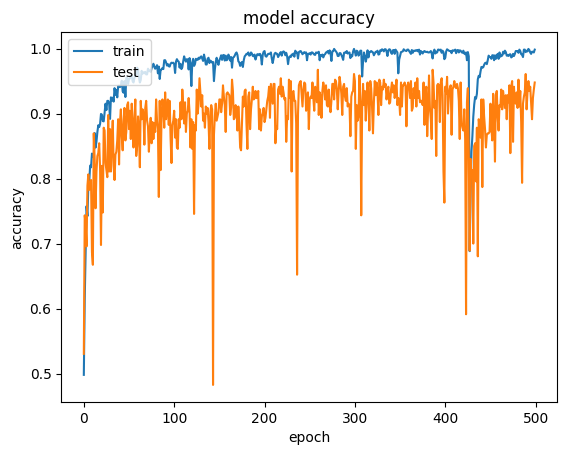

In [19]:
# show history plot
plt.plot(model.history.history["sparse_categorical_accuracy"])
plt.plot(model.history.history["val_sparse_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

15/15 [==============================] - 2s 30ms/step
[[ 45   0   0   0   0   0   4]
 [  0  50   0   0   0   1   1]
 [  0   1  20   0   0   0   0]
 [  0   2   0  24   1   0   7]
 [  0   0   0   0  46   0   0]
 [  0   0   0   0   0  42   3]
 [  2   1   0   0   1   0 209]]


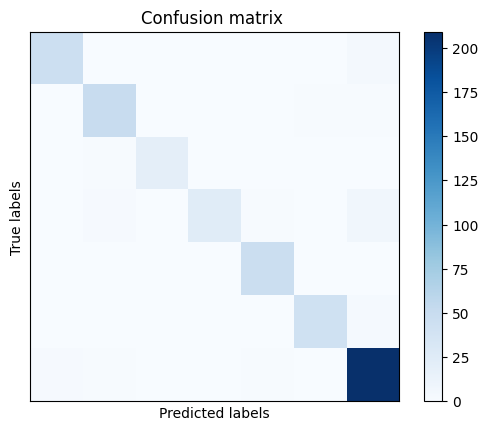

In [20]:
from sklearn.metrics import confusion_matrix

# confusion matrix
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
cm = confusion_matrix(y_true, y_pred)
#cm = [c[0:-1] for c in cm[0:-1]]
print(cm)
# plot
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title("Confusion matrix ")
plt.colorbar()
plt.show()

1/1 [==============================] - 1s 1s/step


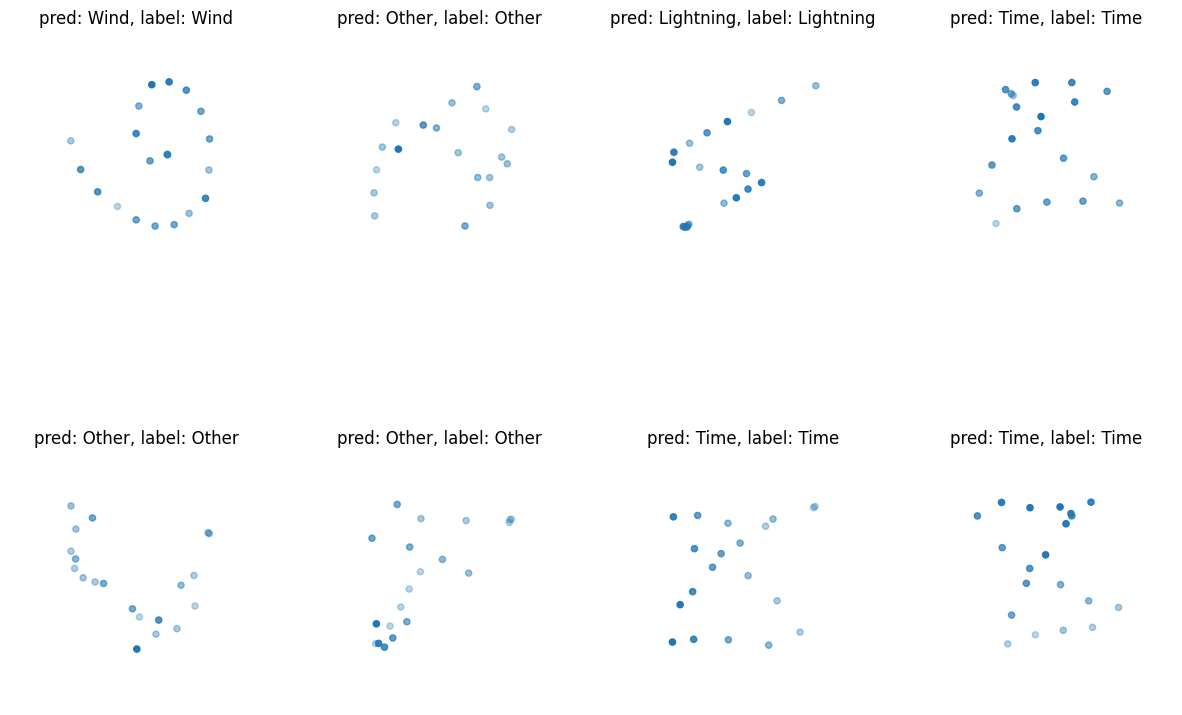

In [21]:
class_map = {}
class_map[0] = "Time"
class_map[1] = "Wind"
class_map[2] = "Fire"
class_map[3] = "Earth"
class_map[4] = "Water"
class_map[5] = "Lightning"
class_map[6] = "Other"

data = train_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
    ax.view_init(elev=90, azim=0, roll=90)
plt.show()


In [22]:
# save with custom objects
model.save('model_3d_with_other_transformer')

model.save('model_3d_with_other_transformer.h5', save_format='h5')

INFO:tensorflow:Assets written to: model_3d_with_other_transformer\assets


INFO:tensorflow:Assets written to: model_3d_with_other_transformer\assets


In [23]:
model.evaluate(test_dataset)

15/15 [==============================] - 1s 40ms/step - loss: 1.4592 - sparse_categorical_accuracy: 0.9478


[1.459168553352356, 0.947826087474823]

In [24]:
!python -m tf2onnx.convert --saved-model best_model_test --output model_3d_with_other_transformer.onnx

C:\Anaconda\envs\tf\lib\runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-11-02 00:19:58,094 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-11-02 00:20:04,481 - INFO - Signatures found in model: [serving_default].
2023-11-02 00:20:04,481 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-11-02 00:20:04,482 - INFO - Output names: ['outputs']
2023-11-02 00:20:06,232 - INFO - Using tensorflow=2.10.1, onnx=1.13.1, tf2onnx=1.14.0/8f8d49
2023-11-02 00:20:06,232 - INFO - Using opset <onnx, 15>
2023-11-02 00:20:06,431 - INFO - Computed 0 values for constant folding
2023-11-02 00:20:06,777 - INFO - Optimizing ONNX model
2023-11-02 00:20:08,196 - INFO - replacing einsum node 'StatefulPartitionedCall/pointnet/multi_head_attention/einsum/Einsum' by its decompose

In [29]:
test_model = keras.models.load_model('model_3d_with_other_transformer', custom_objects={"OrthogonalRegularizerTest": OrthogonalRegularizerTest})

RuntimeError: Unable to restore object of class 'Dense' likely due to name conflict with built-in Keras class '<class 'keras.layers.core.dense.Dense'>'. To override the built-in Keras definition of the object, decorate your class with `@keras.utils.register_keras_serializable` and include that file in your program, or pass your class in a `keras.utils.CustomObjectScope` that wraps this load call.